In [ ]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade tensorflow
#!pip install -q --upgrade keras --use-deprecated=legacy-resolver

In [ ]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip

In [ ]:
#!unzip "indoor_object_detection.zip" -d "dataset/"

## Setup

In [1]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras
from keras_core import ops, random

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random
from tensorflow import clip_by_value

2024-02-02 09:06:29.686793: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 09:06:29.902542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 09:06:29.902581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 09:06:29.938048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 09:06:30.004135: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-02-02 09:07:08.793900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:07:08.893175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:07:08.893216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load Data

## Hyperparameters

In [3]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 3
LEARNING_RATE = 0.001
EPOCH = 10
GLOBAL_CLIPNORM = 10.0
IMG_SIZE = 640
AUTO = tf_data.AUTOTUNE

A dictionary is created to map each class name to a unique numerical identifier. This
mapping is used to encode and decode the class labels during training and inference in
object detection tasks.

In [6]:
class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    "emptychair", "fullchair"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset2/train/"
path_annot = "../dataset2/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [7]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4780 [00:00<?, ?it/s]

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-02-02 09:09:47.919626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:09:47.919713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:09:47.919732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:09:50.736710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 09:09:50.736784: I external/local_xla/xla/stream_executor

Splitting data in training and validation data

In [9]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4780
956
tf.Tensor(3824, shape=(), dtype=int64)


In [11]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

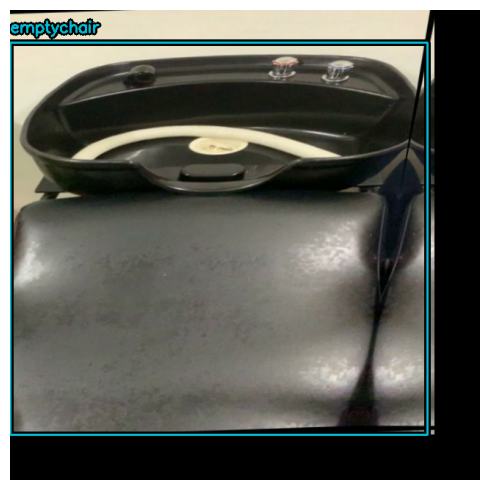

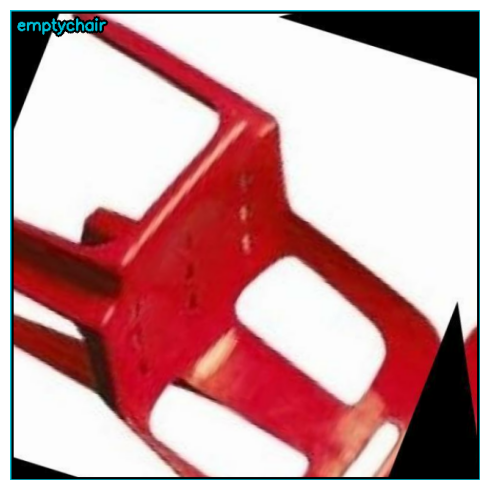

In [15]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=1,
        cols=1,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [16]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds_cmu = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_cmu = train_ds_cmu.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

You can read more about YOLOV8 and its architecture in this
[RoboFlow Blog](https://blog.roboflow.com/whats-new-in-yolov8/)

In [17]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    #trainable = False
)

/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [18]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1
)

## Compile the Model

In [19]:
#tf.keras.backend.clear_session()

In [20]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=False)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [22]:
yolo.load_weights("model-test2-ep12-02022024-021145.h5")
#yolo = keras_cv.models.load("model.h5")

In [ ]:
#yolo.save("model_3ep.h5")

## Train the Model

In [ ]:
yolo.fit(
    train_ds_cmu,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

## Visualize Predictions

2024-02-02 09:16:31.214607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 14745728 bytes after encountering the first element of size 14745728 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-02 09:16:31.217331: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10165342474775066869
2024-02-02 09:16:31.217459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10165342474775066869
2024-02-02 09:16:31.217480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17420554087276201686
2024-02-02 09:16:31.217505: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10165342474775066869
2024-02-02 09:16:31.217512: I tensorflow/core/framework/lo

1/1 [==============================] - 1s 597ms/step


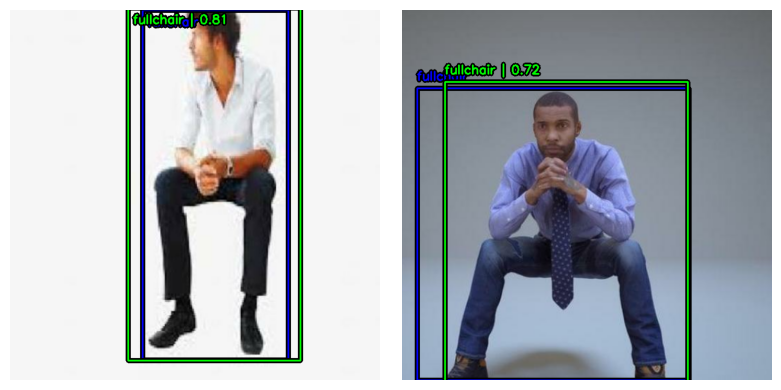

In [35]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(301)))
    #print(images.shape)
    #print(y_true)
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    #print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (0,0,255),
        pred_color = (0,255,0),
        scale=4,
        rows=1,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

(1, 640, 640, 3)
1/1 [==============================] - 0s 477ms/step
{'boxes': <tf.RaggedTensor [[[126.789185, -6.7874756, 626.3739, 597.2898]]]>, 'confidence': <tf.RaggedTensor [[0.75683177]]>, 'classes': <tf.RaggedTensor [[1.0]]>, 'num_detections': array([1], dtype=int32)}


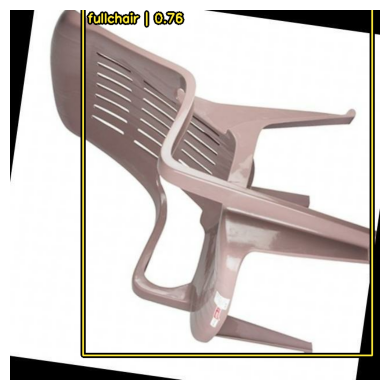

In [41]:
def visualize_generic(model, image_name, bounding_box_format):
    #images = load_image(os.path.join(path_images, image_name))
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [640,640])
    images = tf.cast(image, tf.float32)
    images = tf.expand_dims(images, axis=0)
    print(images.shape)

    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        #y_true={},
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_generic(yolo, image_name="../test_images/testimage_5.jpg", bounding_box_format="xyxy")
#img_0120_jpg.rf.36da0f1b2f59ec13cb70e1b82defd9a0.jpg